# Advanced Lane Detection

## Steps for Project
    1. Calibrate Camera using calibration matrix and distortion coefficients for given chessboard images
    2. Define a Undistortion ultility which undistors any frame of vide using calibration from step #1.
    3. Use perspective transform to get birds eye view of the image.
    4. Create a binary thresold image using sobel, color spaces techiniques taught in lesson.
    5. Find lanes.
    6. Determine curvature of the road.
    7. Unwrap the image back to original shape.
    8. Draw visual display of the lane detected


In [1]:
# Define all imports upfront
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Our utils
from im_utils import read_image, convert_gray

## Step 1: Calibrate camera

### 1.1 Explore Calbiraton images

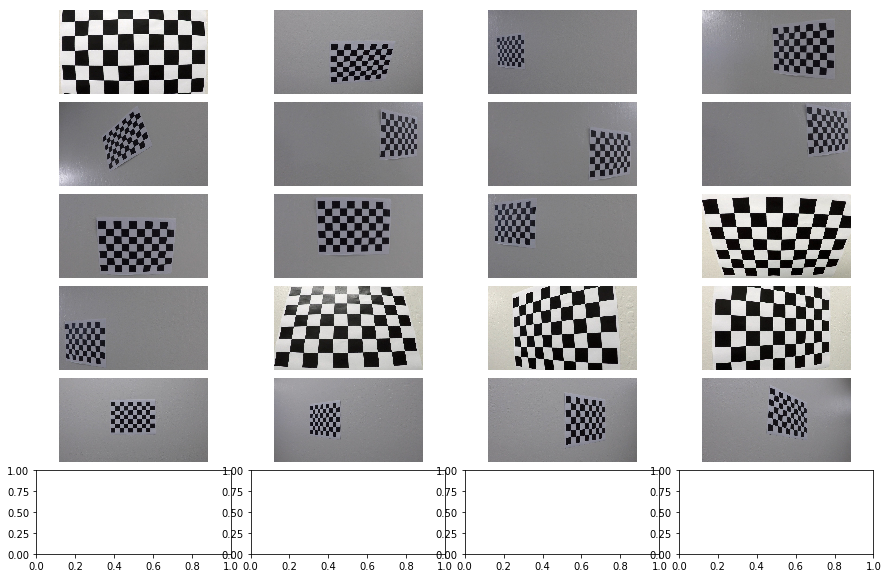

In [8]:
cal_fnames = glob.glob('./camera_cal/calibration*.jpg')

# Explore all images in a 5X4 grid.
def plot_images(images):
    # Plot 4 images per row
    fig, axs = plt.subplots(int(len(images) / 4) + 1, 4, figsize=(15, 10))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    axs = axs.ravel()
    for i, img in enumerate(images):
        axs[i].axis('off')
        axs[i].imshow(img)

        
def explore_calibration_images():
    images = []
    for i, cal_fname in enumerate(cal_fnames):
        img = read_image(cal_fname)
        images.append(img)

    plot_images(images)
    

explore_calibration_images()    
    

### 1.2 Calibrate camera

In [4]:
# Get imagepoints and object points. This is similar to what has been taught in lesson. Except for the fact images provided
# in this project are 9X6

def get_camera_corners(image_paths):
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    objpoints = [] 
    imgpoints = []
    img_with_corners = []
    
    for fname in image_paths:
        img = read_image(fname)
        gr_img = convert_gray(img)
        ret, corners = cv2.findChessboardCorners(gr_img, (9,6), None)
        
        if ret == True:
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            objpoints.append(objp)
            imgpoints.append(corners)
            img_with_corners.append(img)
            
    
    return (img_with_corners, objpoints, imgpoints)

img_with_corners, objpoints, imgpoints = get_camera_corners(cal_fnames)
    

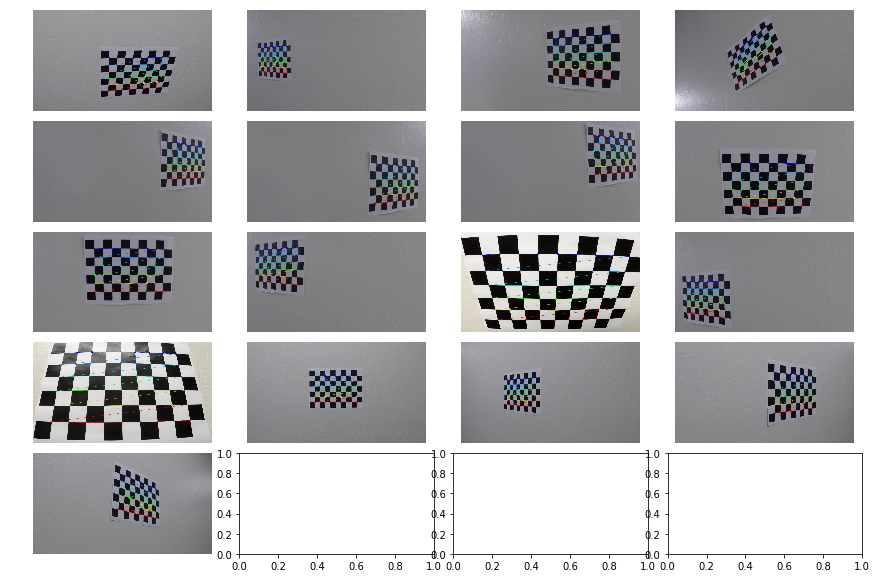

In [5]:
# Explore images after corners have been drawn
plot_images(img_with_corners)

## Step 2: Define a function to undistort images

Text(0.5,1,'UnDistorted Image')

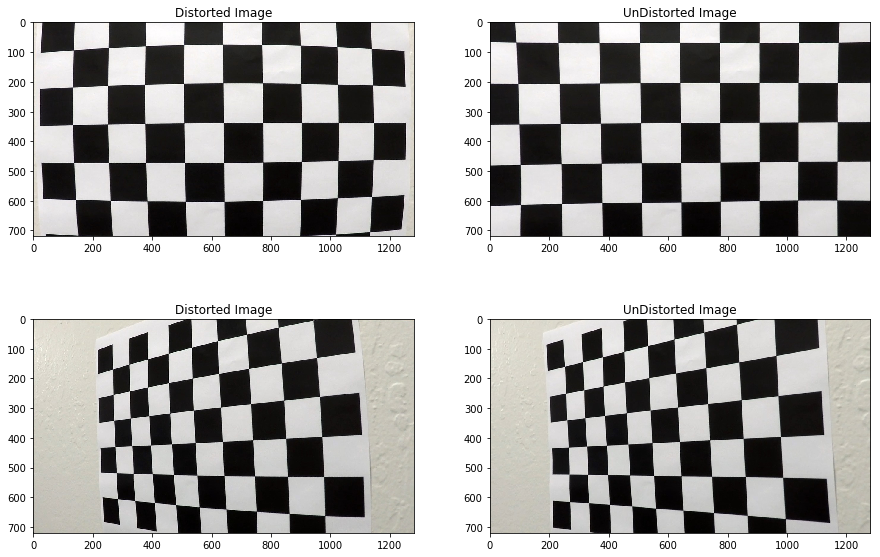

In [59]:
d_img = read_image(cal_fnames[0])
img_size = (d_img.shape[1], d_img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
def undistort_image(dimg):
    undistored = cv2.undistort(dimg, mtx, dist, None, mtx)
    return undistored

# Explore undistortion result
img = read_image('./camera_cal/calibration1.jpg')
dimg = undistort_image(img)

img2 = read_image('./camera_cal/calibration4.jpg')
dimg2 = undistort_image(img2)


f, axs = plt.subplots(2, 2, figsize=(15,10))
axs = axs.ravel()

axs[0].imshow(img)
axs[0].set_title('Distorted Image')
axs[1].imshow(dimg)
axs[1].set_title('UnDistorted Image')

axs[2].imshow(img2)
axs[2].set_title('Distorted Image')
axs[3].imshow(dimg2)
axs[3].set_title('UnDistorted Image')

## Step 3: Warp and unwarp images

### 3.1 Explore test images

Shape of Test images (720, 1280, 3)


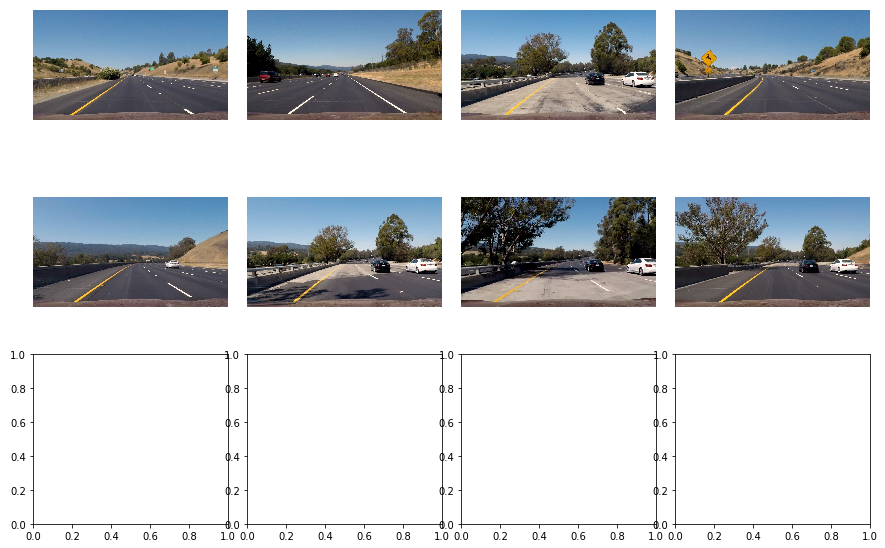

In [60]:
test_fnames = glob.glob('./test_images/*.jpg')

print("Shape of Test images", read_image(test_fnames[0]).shape)
def explore_test_images():
    images = []
    for i, test_fname in enumerate(test_fnames):
        img = read_image(test_fname)
        images.append(img)
    plot_images(images)
    

explore_test_images()    



### 3.2 Define Perspective Transform function

In [61]:
def warp_image(image, mapper):
    return cv2.warpPerspective(image, mapper, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

def do_perspective_transform(image, src, dst):
    """
        returns warped_image, m_inv (which can be used later to invert the image)
    """
    m = cv2.getPerspectiveTransform(src, dst)
    m_inv = cv2.getPerspectiveTransform(dst, src)
    warped_image = warp_image(image, m)
    return warped_image, m_inv

### 3.3 Explore various warp points

In [65]:
def visualize_warp(images, src, dst):
    f, axs = plt.subplots(len(images), 4, figsize=(15,10))
    f.subplots_adjust(hspace = .5, wspace=.1)
    axs = axs.ravel()
    i = 0
    for img in images:
        undis_image = undistort_image(img)
        warped_image, m_inv = do_perspective_transform(undis_image, src, dst)
        unwarped_image = warp_image(warped_image, m_inv)

        axs[i].imshow(img)
        axs[i].set_title('Original image')
        i += 1
        
        axs[i].imshow(undis_image)
        axs[i].set_title('Undistorted image')
        i += 1
        
        axs[i].imshow(warped_image)
        axs[i].set_title('Warped Image')
        i += 1
        
        axs[i].imshow(unwarped_image)
        axs[i].set_title('UnWarped Image')
        i += 1
        

In [72]:
testimgs = []
for test_fname in test_fnames[0:5]:
    testimgs.append(read_image(test_fname))
    
def test1_src_dest():
    height, width, _ = img.shape

    src = np.float32([(520.,410.),
                      (685.,410.), 
                      (225.,660.),
                      (1130.,660.) 
                      ])

    dst = np.float32([(400.,0),
                      (width-400.,0),
                      (400.,height),
                      (width-400.,height)])

    visualize_warp(testimgs, src, dst)
    return src, dst
        
def test2_src_dest():
    img = read_image(test_fnames[2])
    height, width, _ = img.shape

    src = np.float32([(570.,450.),
                      (705.,450.), 
                      (255.,670.),
                      (1110.,670.) 
                      ])

    dst = np.float32([(445.,0),
                      (width-445.,0),
                      (445.,height),
                      (width-445.,height)])

    visualize_warp(testimgs, src, dst)
    return src, dst

def test3_src_dest():
    img = read_image(test_fnames[2])
    height, width, _ = img.shape

    src = np.float32([(580.,460.),
                      (720.,460.), 
                      (255.,680.),
                      (1090.,680.) 
                      ])

    dst = np.float32([(445.,0),
                      (width-445.,0),
                      (445.,height),
                      (width-445.,height)])

    visualize_warp(testimgs, src, dst)    
    return src, dst

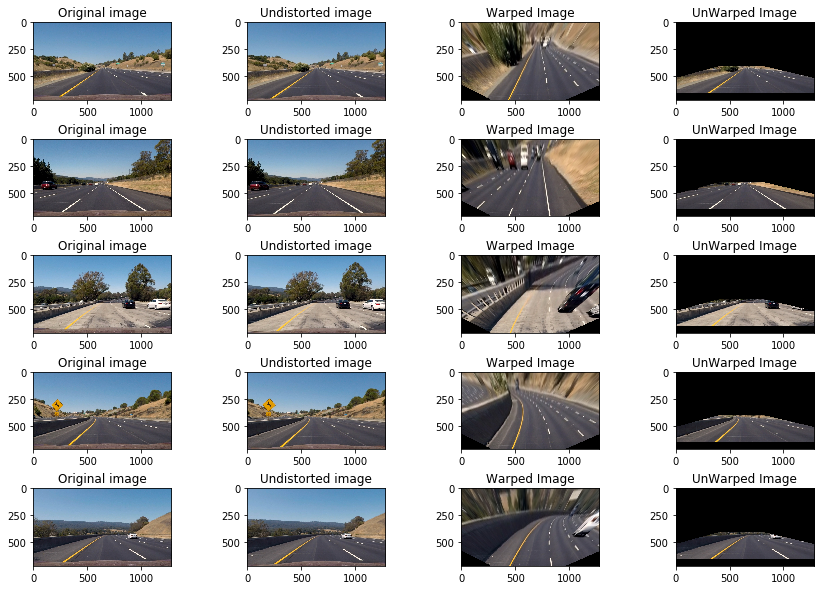

In [73]:
src1, dst1 = test1_src_dest()

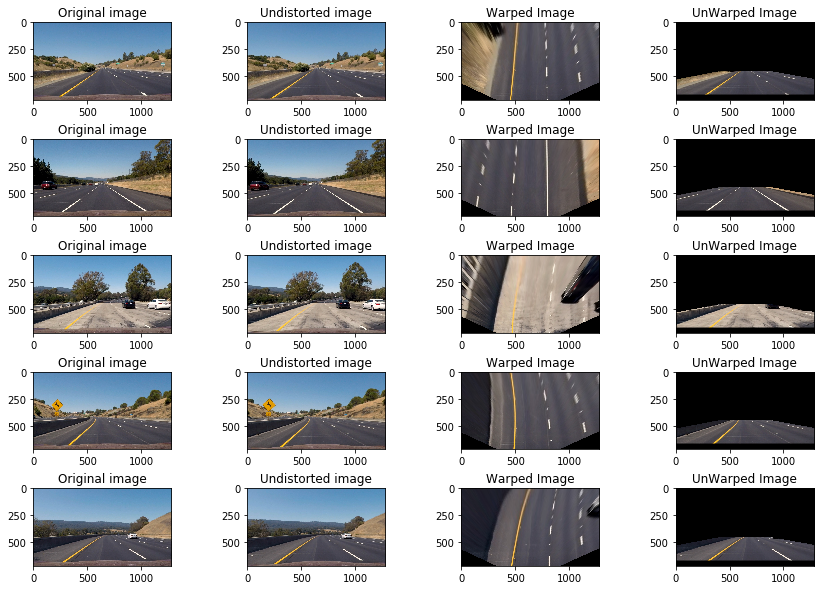

In [74]:
src2, dst2 = test2_src_dest()

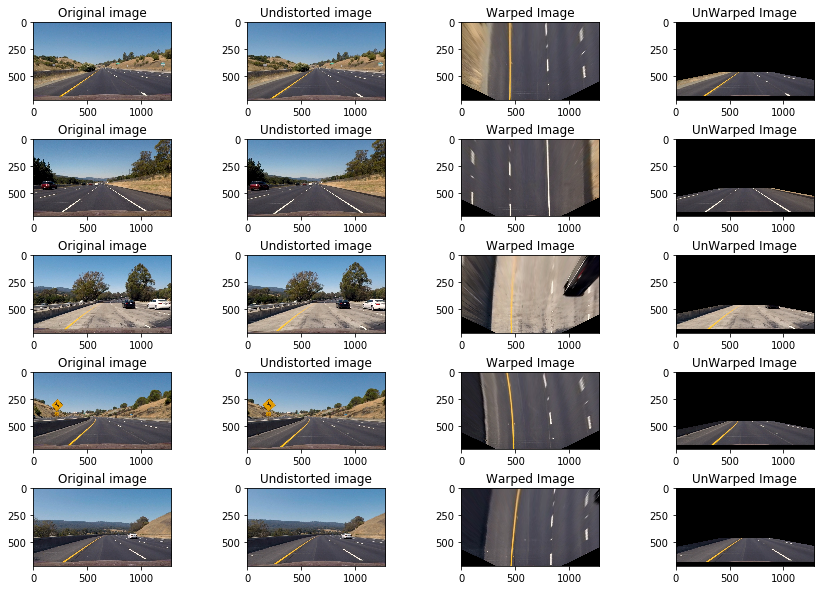

In [75]:
src3, dst3 = test3_src_dest()

### 3.4 Final warp points

In [76]:
final_src, final_dist = src3, dst3